In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

/home/muttaqien-m/anaconda3/envs/tsuc2023/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/muttaqien-m/anaconda3/envs/tsuc2023/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Load Image

In [2]:
image_path = "./letter/letterbox.png"
image = cv2.imread(image_path)

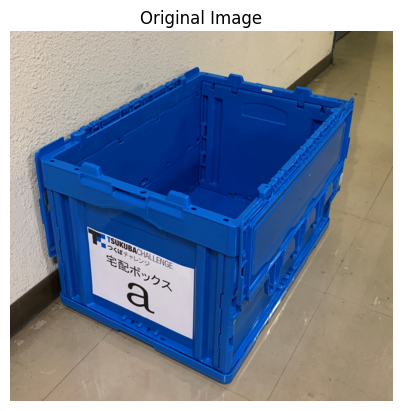

In [3]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

## Preprocess Image

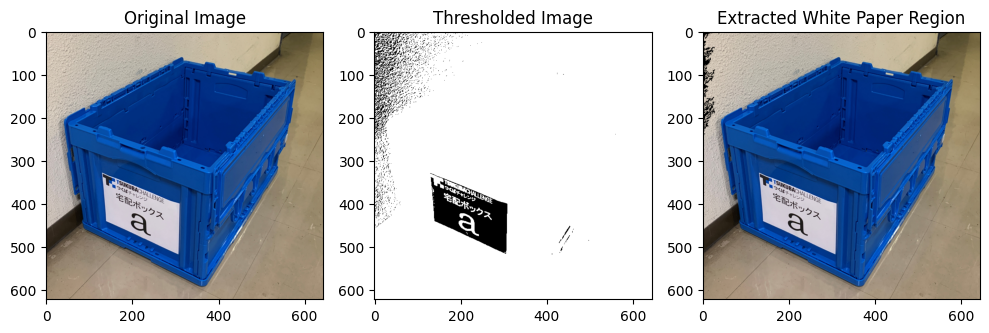

In [4]:
# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to create a binary mask (white paper will be white, and the rest black)
_, thresholded = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours in the binary image
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with the largest area (assuming it corresponds to the white paper)
largest_contour = max(contours, key=cv2.contourArea)

# Create a mask for the white paper region
mask = np.zeros_like(thresholded)
cv2.drawContours(mask, [largest_contour], 0, 255, thickness=cv2.FILLED)

# Bitwise AND operation to extract the white paper region
result = cv2.bitwise_and(image, image, mask=mask)

# Display the original image, thresholded image, and the result
plt.figure(figsize=(10, 6))

plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(132)
plt.imshow(thresholded, cmap='gray')
plt.title('Thresholded Image')

plt.subplot(133)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Extracted White Paper Region')

plt.tight_layout()
plt.show()

## Classify Image

In [5]:
# Define the LeNet-3 architecture for A, B, C classification
class LeNet3(nn.Module):
    def __init__(self):
        super(LeNet3, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 3)  # Output for A, B, C

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Initialize the model, loss function, and optimizer
model = LeNet3().to(device)

In [7]:
model.load_state_dict(torch.load('./weights/lenet.pth'))  # Replace with the actual path to your trained model
model.eval()

# Convert the zoomed-in image to a PIL Image
thresholded_in_pil = Image.fromarray(cv2.cvtColor(thresholded, cv2.COLOR_BGR2RGB))

# Preprocess the zoomed-in image for LeNet
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

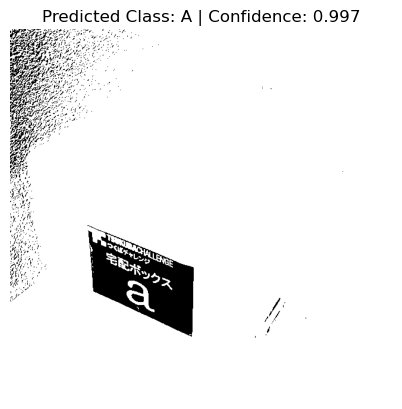

In [8]:
input_image = transform(thresholded_in_pil)
input_image = input_image.unsqueeze(0).to(device)

# Make a prediction using the LeNet model
with torch.no_grad():
    output = model(input_image)

# Get the predicted class and confidence scores
_, predicted = torch.max(output, 1)
predicted_class = predicted.item()

# Display the confidence scores
confidence = torch.softmax(output, dim=1)[0][predicted.item()].item()
class_names = ['A', 'B', 'C']  # Adjust according to your class names

# Display the zoomed-in image with the predicted class and confidence scores
plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_BGR2RGB))
plt.title(f'Predicted Class: {class_names[predicted_class]} | Confidence: {confidence:.3f}')
plt.axis('off')
plt.show()

---